In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

import pickle
from sklearn.decomposition import PCA

In [2]:
### hmm lets see, how do I rebuild this?
# I need both the PCs over time (got them), and PC weights on the voxels

In [3]:
### PCs over time:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_temporal.npy'
temporal = np.load(file)
temporal.shape #timepoint by PC

(30456, 1000)

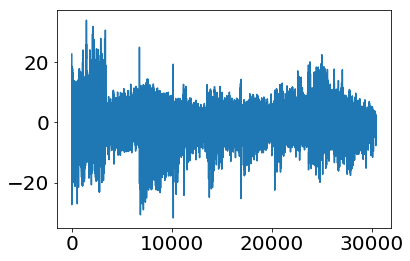

In [28]:
plt.plot(temporal[:,0])

In [4]:
### PCs over voxels:
file = F'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_eigen_values_ztrim.npy'
values = np.load(file).real
print(values.shape)

file = F'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_eigen_vectors_ztrim.npy'
vectors = np.load(file).real
print(vectors.shape)# vectors is voxel by PC

(26840,)
(26840, 26840)


In [33]:
### Ok lets test by rebuilding from first x PCs
num_pcs = 500
#temporal[:,:num_pcs] # 30456 by x
#vectors[:,:num_pcs] # 26840 by x
out = np.matmul(temporal[:,:num_pcs], vectors[:,:num_pcs].T)
out.shape #time by voxels

(30456, 26840)

In [67]:
temporal.shape

(30456, 26840)

In [68]:
### CREATING RECONSTRUCTED DATA ###

### Ok lets test by rebuilding from first x PCs
for num_pcs in [1,10,30,50,100,500,1000,10000,26840]:
    print(num_pcs)
    #temporal[:,:num_pcs] # 30456 by x
    #vectors[:,:num_pcs] # 26840 by x
    out = np.matmul(temporal[:,:num_pcs], vectors[:,:num_pcs].T)
    #out.shape #time by voxels
    file = F'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210216_reconstructed_{num_pcs}'
    np.save(file, out)

1
10
30
50
100
500
1000
10000
26840


In [70]:
out.shape

(30456, 26840)

In [ ]:
#now out is time by voxels - looks correct probably
#lets visualize spatial and temporal

In [7]:
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/labels.pickle'
with open(labels_file, 'rb') as handle:
    cluster_model_labels = pickle.load(handle)

In [71]:
running_sum = 0
new = []
for z in range(9,49-9):
    num_clusters = len(np.unique(cluster_model_labels[z]))
    new.append(out[:,running_sum:num_clusters+running_sum])
    running_sum += num_clusters

In [72]:
new[0].shape

(30456, 576)

In [77]:
num_tp = 3384
i=8
start = i*num_tp
print(start)
stop = (i+1)*num_tp
print(stop)
new[0][start:stop,:].shape

27072
30456


(3384, 576)

In [79]:
z=20
cluster_num=100
np.where(cluster_model_labels[z]==cluster_num)[0]

(array([17235, 17236, 17237, 17363, 17364, 17365, 17491, 17492, 17493,
        17494, 17619, 17620, 17621, 17622, 17747]),)

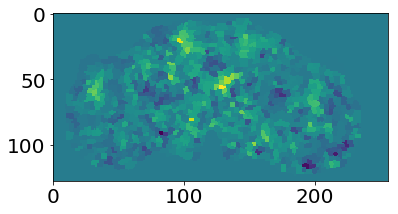

In [42]:
z=20
timepoint = 504
colored_by_betas = np.zeros((256*128))
for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
    cluster_indicies = np.where(cluster_model_labels[z][:]==cluster_num)[0]
    colored_by_betas[cluster_indicies] = new[z-9][timepoint,cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T,cmap='viridis_r')

### Testing whether I should weight by eigenvalues. It seems not

In [47]:
load_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/super_brain.pickle'
with open(load_file, 'rb') as handle:
    temp_brain = pickle.load(handle)
#brain is a dict of z, each containing a variable number of supervoxels
#one dict element looks like: (n_clusters, 3384, 9)
X = np.zeros((0,3384,9))
for z in range(9,49-9):
    X = np.concatenate((X,temp_brain[z]),axis=0)

In [48]:
X = np.swapaxes(X,1,2) # THIS LINE WAS MISSING
X = np.reshape(X,(26840, -1))
X = X.T
X.shape # x is time by voxels

(30456, 26840)

In [49]:
vectors.shape

(26840, 26840)

In [50]:
t0 = time.time()
temporal = X.dot(vectors)
print(time.time()-t0)
temporal.shape #timepoint by PC

83.6605007648468


(30456, 26840)

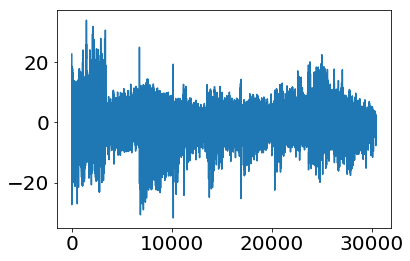

In [51]:
plt.plot(temporal[:,0])

In [63]:
### Ok lets test by rebuilding from first 2 PCs
num_pcs = 100
#temporal[:,:num_pcs] # 30456 by 2
#vectors[:,:num_pcs] # 26840 by 2
out = np.matmul(temporal[:,:num_pcs], vectors[:,:num_pcs].T)
out.shape #time by voxels

(30456, 26840)

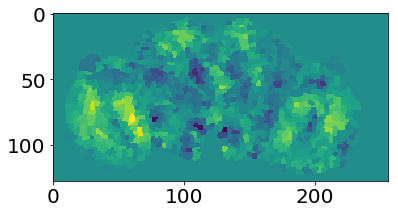

In [64]:
### reconstructed from 100 PCs ###

running_sum = 0
new = []
for z in range(9,49-9):
    num_clusters = len(np.unique(cluster_model_labels[z]))
    new.append(out[:,running_sum:num_clusters+running_sum])
    running_sum += num_clusters
    
z=20
timepoint = 500
colored_by_betas = np.zeros((256*128))
for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
    cluster_indicies = np.where(cluster_model_labels[z][:]==cluster_num)[0]
    colored_by_betas[cluster_indicies] = new[z-9][timepoint,cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T,cmap='viridis_r')

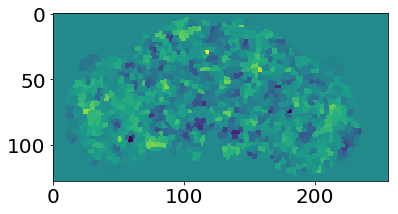

In [62]:
### reconstructed from 1000 PCs ###

running_sum = 0
new = []
for z in range(9,49-9):
    num_clusters = len(np.unique(cluster_model_labels[z]))
    new.append(out[:,running_sum:num_clusters+running_sum])
    running_sum += num_clusters
    
z=20
timepoint = 500
colored_by_betas = np.zeros((256*128))
for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
    cluster_indicies = np.where(cluster_model_labels[z][:]==cluster_num)[0]
    colored_by_betas[cluster_indicies] = new[z-9][timepoint,cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T,cmap='viridis_r')

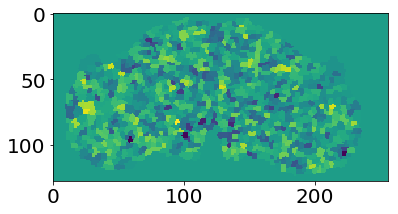

In [60]:
### reconstructed from ~half PCs ###

running_sum = 0
new = []
for z in range(9,49-9):
    num_clusters = len(np.unique(cluster_model_labels[z]))
    new.append(out[:,running_sum:num_clusters+running_sum])
    running_sum += num_clusters
    
z=20
timepoint = 500
colored_by_betas = np.zeros((256*128))
for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
    cluster_indicies = np.where(cluster_model_labels[z][:]==cluster_num)[0]
    colored_by_betas[cluster_indicies] = new[z-9][timepoint,cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T,cmap='viridis_r')

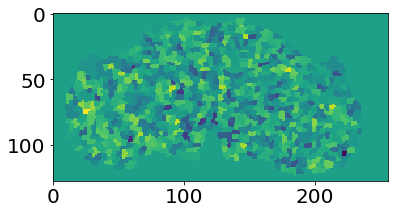

In [56]:
### reconstructed from all PCs ###

running_sum = 0
new = []
for z in range(9,49-9):
    num_clusters = len(np.unique(cluster_model_labels[z]))
    new.append(out[:,running_sum:num_clusters+running_sum])
    running_sum += num_clusters
    
z=20
timepoint = 500
colored_by_betas = np.zeros((256*128))
for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
    cluster_indicies = np.where(cluster_model_labels[z][:]==cluster_num)[0]
    colored_by_betas[cluster_indicies] = new[z-9][timepoint,cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T,cmap='viridis_r')

In [57]:
X.shape #time by voxels

(30456, 26840)

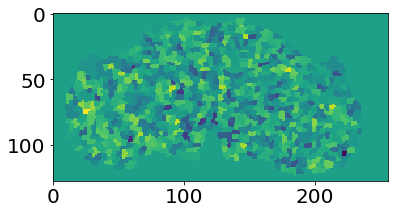

In [58]:
### Raw data ###

running_sum = 0
new = []
for z in range(9,49-9):
    num_clusters = len(np.unique(cluster_model_labels[z]))
    new.append(X[:,running_sum:num_clusters+running_sum])
    running_sum += num_clusters
    
z=20
timepoint = 500
colored_by_betas = np.zeros((256*128))
for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
    cluster_indicies = np.where(cluster_model_labels[z][:]==cluster_num)[0]
    colored_by_betas[cluster_indicies] = new[z-9][timepoint,cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T,cmap='viridis_r')

In [ ]:
### they look indentical, suggesting I should not weight PCs by eigenvalues

In [ ]:
### final conclusion, i do not need to do this weighting:

### Oops - I actually think we need to scale the temporal PCs by their values, right?
# Each shouldn't have a equal contribution. idk if this is true
## ooo i can test by comparing reconstructed data to real data and seeing which is correct
#like this:
# U, s, Vt = LA.svd(face_data, full_matrices=False)
# S = np.diag(s)
# #U: 500 *500, S: 500 *500, Vt:500 *2914
# dim = 100 
# US = U[:, 0:dim].dot(S[0:dim, 0:dim])

num_pcs = 500
#temporal[:,:num_pcs] # 30456 by 2
#vectors[:,:num_pcs] # 26840 by 2
values_diag = np.diag(values)



out = np.matmul(temporal[:,:num_pcs], np.dot(vectors[:,:num_pcs].T,values_diag[:,:num_pcs]))
out.shape

In [65]:
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z) #<---------- !!!
brain = np.array(nib.load(brain_file).get_data(), copy=True)
fly_idx_delete = 3 #(fly_095)
brain = np.delete(brain, fly_idx_delete, axis=-1) #### DELETING FLY_095 ####

In [66]:
brain.shape

(256, 128, 3384, 9)